<a href="https://colab.research.google.com/github/amanteur/TDA_Cover_detection/blob/main/Practics/TDA_CoverDetection_Practics_3_SiameseNetwork_TripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import FloatTensor
import tqdm
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/CourseWork/pers_feat_datasets/'
df_dict = {}
for _, _, files in os.walk(root_dir):
  for file in files:
    name = file.split('.')[0]
    df = pd.read_json(root_dir + file)
    df_dict [name] = df

### Creating own dataset

In [12]:
#our dataset
class MyDataset(Dataset):
  def __init__(self, df, setSize, feature='Silhouette'):
    self.df = df
    self.feature = feature
    self.setSize = setSize
  def __len__(self):
    return self.setSize
  #creating separate dataframes for originals and covers
  def _separate_dfs(self, df):
    df_query = df.drop_duplicates(['name'])
    df_search = df[~df.index.isin(df_query.index)]
    return df_query, df_search
  def __getitem__(self, idx):
    origs, covers = self._separate_dfs(self.df)

    anchor = origs.sample()[['name', self.feature]]
    anchor_name = anchor['name'].iloc[0]

    pos = covers.loc[covers['name'] == anchor_name].sample()[self.feature]
    neg = df.loc[df['name'] != anchor_name].sample()[self.feature]
    return FloatTensor(anchor[self.feature].iloc[0]), \
           FloatTensor(pos.iloc[0]), \
           FloatTensor(neg.iloc[0])

In [13]:
class OneShotEvalSet(Dataset):
  def __init__(self, df, setSize, nWay, feature='Silhouette'):
    self.df = df
    self.feature = feature
    self.setSize = setSize
    self.nWay = nWay
  def __len__(self):
    return self.setSize
  def __getitem__(self, idx):
    # get main song
    song_init = self.df.sample()[['name', self.feature]]
    song_name = song_init['name'].iloc[0]
    # first song is the same
    testSet = [FloatTensor(self.df.loc[(self.df['name'] == song_name) & (self.df.index != song_init.index[0])].sample()[self.feature].iloc[0])]
    song_search_idx = []
    for i in range(self.nWay - 1):
      song_search = self.df.loc[self.df['name'] != song_name].sample()[self.feature]
      while song_search.index[0] in song_search_idx:
        song_search = self.df.loc[self.df['name'] != song_name].sample()[self.feature]
      song_search = FloatTensor(song_search.iloc[0])
      testSet.append(song_search)
    return FloatTensor(song_init[self.feature].iloc[0]), \
           testSet

In [14]:
#splitting in train and test
from sklearn.model_selection import train_test_split

def split_data(df_dict, label_col='name', test_size=0.2, random_state=42):
  #extracting labels aka songs' names
  labels = set(df_dict[np.random.choice(list(df_dict))][label_col].tolist())
  #making train/test labels
  lbl_train, lbl_test = train_test_split(list(labels), test_size=test_size, random_state=random_state)

  train_test_dict = {}
  for name, df in df_dict.items():
    train_df = df[df[label_col].isin(lbl_train)]
    test_df = df[df[label_col].isin(lbl_test)]

    train_test_dict.setdefault(name,{})
    train_test_dict[name]['train'] = train_df
    train_test_dict[name]['test'] = test_df

  return train_test_dict

In [15]:
train_test_dict = split_data(df_dict, test_size=0.2)

In [16]:
#defining train val datasets
dataSize = 1000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

train_df = train_test_dict['ms_orig']['train']
dataset = MyDataset(df_dict['ms_orig'], dataSize)
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=16, num_workers=2)
val_loader = DataLoader(val_set, batch_size=1, num_workers=2, shuffle=True)

In [17]:
# create the test set for final testing
testSize = 200
numWay = 10
test_df = train_test_dict['ms_orig']['test']
test_set = OneShotEvalSet(df_dict['ms_orig'], testSize, numWay)
test_loader = DataLoader(test_set, batch_size = 1, num_workers = 1, shuffle=True)

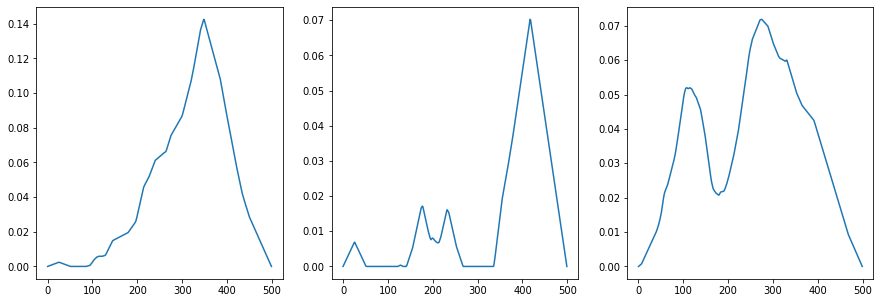

In [18]:
# showing a sample input of a training set
plt.figure(figsize=(15, 5))
for anc, pos, neg in train_loader:
    plt.subplot(1,3,1)
    plt.plot(anc[0][0])
    plt.subplot(1,3,2)
    plt.plot(pos[0][0])
    plt.subplot(1,3,3)
    plt.plot(neg[0][0])
    break

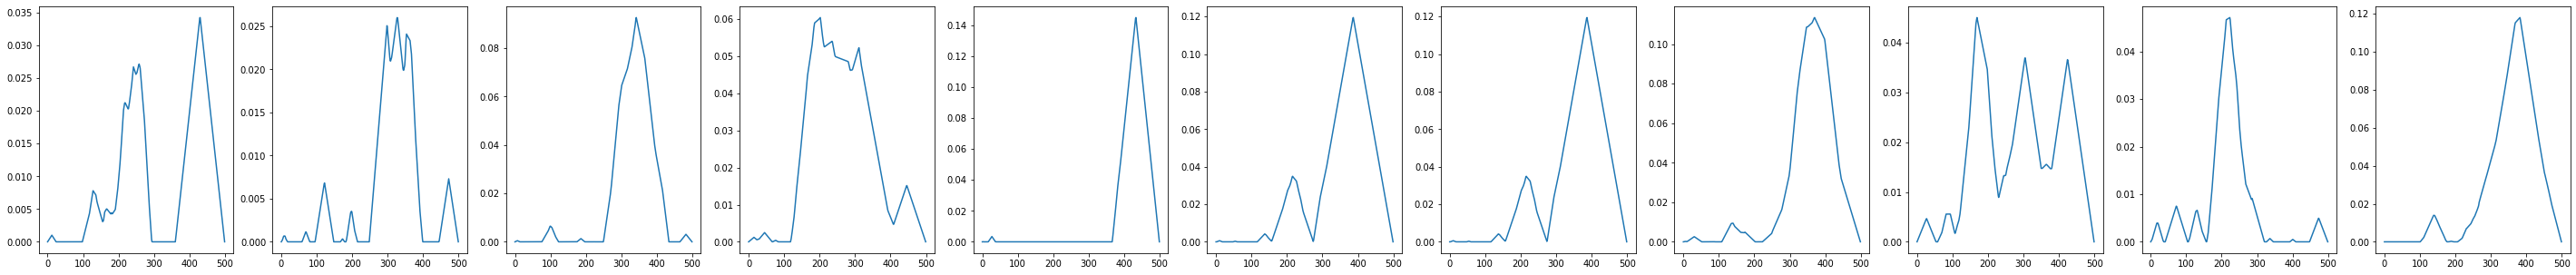

In [19]:
# showing a sample input of the testing set
count = 0
plt.figure(figsize=(50, 5))
for mainSong, songset in test_loader:
  for count, song in enumerate(songset):
    plt.subplot(1, len(songset)+1, count+1)
    plt.plot(song[0][0])
  plt.subplot(1, len(songset)+1, len(songset)+1)
  plt.plot(mainSong[0][0])
  count += 1
  break

# Siamese net with Triplet loss

In [49]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear1 = nn.Linear(500, 256)
    self.linear2 = nn.Linear(500, 256)
    self.out1 = nn.Linear(256, 128)
    self.out2 = nn.Linear(256, 128)

  def fc_pn(self, x):
    x = F.gelu(self.linear1(x))
    x = self.out1(x)
    return x
  
  def fc_a(self, x):
    x = F.gelu(self.linear2(x))
    x = self.out2(x)
    return x
  
  def forward(self, a, p=None, n=None):
    a = self.fc_a(a)
    if p == None and n == None:
      return a 
    else:
      p = self.fc_pn(p)
      n = self.fc_pn(n)
      return a, p, n

In [50]:
class TripletLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(TripletLoss, self).__init__()
    self.margin = margin
      
  def calc_euclidean(self, x1, x2):
    return (x1 - x2).pow(2).sum(1)
  
  def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
    distance_positive = self.calc_euclidean(anchor, positive)
    distance_negative = self.calc_euclidean(anchor, negative)
    losses = torch.relu(distance_positive - distance_negative + self.margin)

    return losses.mean()

In [51]:
#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseTriplet = Net()
siameseTriplet = siameseTriplet.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseTriplet)

The model architecture:

 Net(
  (linear1): Linear(in_features=500, out_features=256, bias=True)
  (linear2): Linear(in_features=500, out_features=256, bias=True)
  (out1): Linear(in_features=256, out_features=128, bias=True)
  (out2): Linear(in_features=256, out_features=128, bias=True)
)

The model has 322,304 trainable parameters


In [52]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer, save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [53]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for anchor, pos, neg in train_loader:

            # Forward
            anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)

            anchor_output, pos_output, neg_output = model(anchor, pos, neg)
            loss = criterion(anchor_output, pos_output, neg_output)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for anchor, pos, neg in val_loader:
                anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)
                anchor_output, pos_output, neg_output = model(anchor, pos, neg)
                loss = criterion(anchor_output, pos_output, neg_output)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

In [60]:
# actual training
import torch.optim as optim

optimizer = optim.Adam(siameseTriplet.parameters(), lr = 0.001)
num_epochs = 100
criterion = TripletLoss()
# criterion = nn.TripletMarginLoss(margin=1)
# criterion = nn.TripletMarginWithDistanceLoss(margin=1, distance_function=nn.CosineSimilarity(dim=2))
save_path = 'siameseNet.pt'
train_losses, val_losses = train(siameseTriplet, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/100],Train Loss: 0.0770, Valid Loss: 0.01759663
Model saved to ==> siameseNet.pt
Starting epoch 2
Epoch [2/100],Train Loss: 0.0376, Valid Loss: 0.02822280
Starting epoch 3
Epoch [3/100],Train Loss: 0.0515, Valid Loss: 0.06300384
Starting epoch 4
Epoch [4/100],Train Loss: 0.0487, Valid Loss: 0.06446920
Starting epoch 5
Epoch [5/100],Train Loss: 0.0426, Valid Loss: 0.07212461
Starting epoch 6
Epoch [6/100],Train Loss: 0.0453, Valid Loss: 0.06945275
Starting epoch 7
Epoch [7/100],Train Loss: 0.0350, Valid Loss: 0.04540123
Starting epoch 8
Epoch [8/100],Train Loss: 0.0545, Valid Loss: 0.03923632
Starting epoch 9
Epoch [9/100],Train Loss: 0.0457, Valid Loss: 0.08844733
Starting epoch 10
Epoch [10/100],Train Loss: 0.0381, Valid Loss: 0.01543626
Model saved to ==> siameseNet.pt
Starting epoch 11
Epoch [11/100],Train Loss: 0.0237, Valid Loss: 0.03809855
Starting epoch 12
Epoch [12/100],Train Loss: 0.0334, Valid Loss: 0.01386190
Model saved to ==> siameseNet.pt
Startin

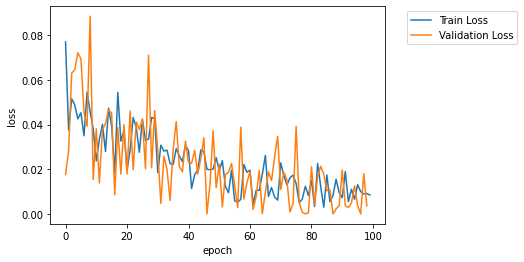

In [62]:
#plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses[:-1], label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [63]:
from collections import Counter

# evaluation metrics
def eval(model, test_loader, at=3):
    with torch.no_grad():
        model.eval()
        print('Starting Iteration')
        count = 0
        prec = 0
        batch_rank = []
        for mainSong, songSet in test_loader:
            mainSong = mainSong.to(device)
            output_main = model(mainSong)
            output_list = []
            for i, testSong in enumerate(songSet):
                testSong = testSong.to(device)
                output_set = model(testSong)
                cos = nn.CosineSimilarity(dim=2, eps=1e-6)
                output = cos(output_main, output_set)
                output_list.append(output.item())
            #computing rank within batch
            true_score = output_list[0]
            output_list.sort(reverse=True)
            rank = output_list.index(true_score) + 1
            batch_rank.append(rank)
            #computing precision
            if rank <= at:
              prec += 1
            #computing accuracy
            count += 1
            if count % 10 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(Counter(batch_rank)[1]/count))
        #metrics
        print(Counter(batch_rank).most_common())
        mean_rank = sum(batch_rank)/count
        mAP = 1/mean_rank
        final_acc = Counter(batch_rank)[1]/count
        prec_at = prec / count
    return mean_rank, mAP, prec_at, final_acc

In [64]:
# Evaluation on previously saved models
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0006)

num_epochs = 10
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer, save_path)

print(best_val_loss)
eval(load_model, test_loader)

Model loaded from <== siameseNet.pt
0.0
Starting Iteration
Current Count is: 10
Accuracy on n way: 0.0
Current Count is: 20
Accuracy on n way: 0.0
Current Count is: 30
Accuracy on n way: 0.0
Current Count is: 40
Accuracy on n way: 0.025
Current Count is: 50
Accuracy on n way: 0.1
Current Count is: 60
Accuracy on n way: 0.11666666666666667
Current Count is: 70
Accuracy on n way: 0.1
Current Count is: 80
Accuracy on n way: 0.1
Current Count is: 90
Accuracy on n way: 0.12222222222222222
Current Count is: 100
Accuracy on n way: 0.11
Current Count is: 110
Accuracy on n way: 0.10909090909090909
Current Count is: 120
Accuracy on n way: 0.11666666666666667
Current Count is: 130
Accuracy on n way: 0.1076923076923077
Current Count is: 140
Accuracy on n way: 0.10714285714285714
Current Count is: 150
Accuracy on n way: 0.10666666666666667
Current Count is: 160
Accuracy on n way: 0.1125
Current Count is: 170
Accuracy on n way: 0.11176470588235295
Current Count is: 180
Accuracy on n way: 0.116666666

(5.14, 0.19455252918287938, 0.295, 0.105)